ПЕРВАЯ ЧАСТЬ: дизайн

1. Определение ключевых метрик

Основные метрики для теста:

CTR (кликабельность рекламы): clicks / views

CR (конверсия в добавление): adds / clicks

CR в заказ (если есть данные по заказам): orders / clicks

ARPU (выручка на пользователя): revenue / total_users

ARPPU (выручка на покупателя): revenue / paying_users

Ключевая метрика: конверсия в добавление товаров в корзину от захода в рекламу (CR = adds / clicks).
Эта метрика показывает, насколько эффективно рекламный блок стимулирует пользователей к добавлению товаров.

2. Подготовка данных (воронка действий)

(а) Загрузка данных

Сначала загружаем данные из data_raw.csv и изучаем их структуру:

In [17]:
import pandas as pd

# Загрузка данных
df = pd.read_csv('G:\Мой диск\zerocoder\Final_case\data_raw.csv')

# Проверка структуры
print(df.head())
print(df.info())
print(df['event_type'].value_counts())


<>:4: SyntaxWarning: invalid escape sequence '\z'
<>:4: SyntaxWarning: invalid escape sequence '\z'
C:\Users\vladi\AppData\Local\Temp\ipykernel_5156\1890157119.py:4: SyntaxWarning: invalid escape sequence '\z'
  df = pd.read_csv('G:\Мой диск\zerocoder\Final_case\data_raw.csv')


   Unnamed: 0  client_id          dt event_type
0           0    6095092  2024-06-20     clicks
1           1  541138559  2024-06-18     clicks
2           2   12189072  2024-06-20     clicks
3           3  674385020  2024-06-20     clicks
4           4  726939378  2024-06-20     clicks
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27756048 entries, 0 to 27756047
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   client_id   int64 
 2   dt          object
 3   event_type  object
dtypes: int64(2), object(2)
memory usage: 847.0+ MB
None
event_type
views     27006473
clicks      535927
adds        213648
Name: count, dtype: int64


(б) Приведение данных к формату воронки
Создадим таблицу с воронкой по датам и пользователям.

In [2]:
# Преобразуем дату в нужный формат
df['dt'] = pd.to_datetime(df['dt'])

# Группируем данные по дате и пользователю, подсчитывая количество каждого события
df_funnel = df.groupby(['dt', 'client_id'])['event_type'].value_counts().unstack(fill_value=0)

# Преобразуем в бинарные значения (0/1), был ли хотя бы 1 event за день
df_funnel = df_funnel.applymap(lambda x: 1 if x > 0 else 0)

# Сбрасываем индекс для удобства
df_funnel.reset_index(inplace=True)

df_funnel.head(10)


C:\Users\vladi\AppData\Local\Temp\ipykernel_5156\3610860607.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_funnel = df_funnel.applymap(lambda x: 1 if x > 0 else 0)


event_type,dt,client_id,adds,clicks,views
0,2024-06-17,1,0,0,1
1,2024-06-17,3,0,1,1
2,2024-06-17,19,0,0,1
3,2024-06-17,37,0,0,1
4,2024-06-17,41,0,0,1
5,2024-06-17,68,0,0,1
6,2024-06-17,106,0,0,1
7,2024-06-17,163,0,0,1
8,2024-06-17,173,0,0,1
9,2024-06-17,178,0,0,1


3. Пользовательское поведение до эксперимента: вывести с помощью графиков ключевые метрики пользователей (средний чек корзины, частота кликов, конверсия в добавления)

In [3]:
import pandas as pd

# Группировка данных по 'client_id' и суммирование значений
aggregated_df = df_funnel.groupby('client_id').agg({
    'adds': 'sum',
    'clicks': 'sum',
    'views': 'sum'
}).reset_index()

# Вывод результата
print(aggregated_df)


event_type  client_id  adds  clicks  views
0                   1     0       0      2
1                   3     1       3      4
2                   4     0       0      4
3                  19     0       0      4
4                  27     0       0      2
...               ...   ...     ...    ...
3102731     957956102     0       0      1
3102732     957956731     0       0      1
3102733     957956796     0       0      2
3102734     957956933     0       0      1
3102735     957958290     0       0      3

[3102736 rows x 4 columns]


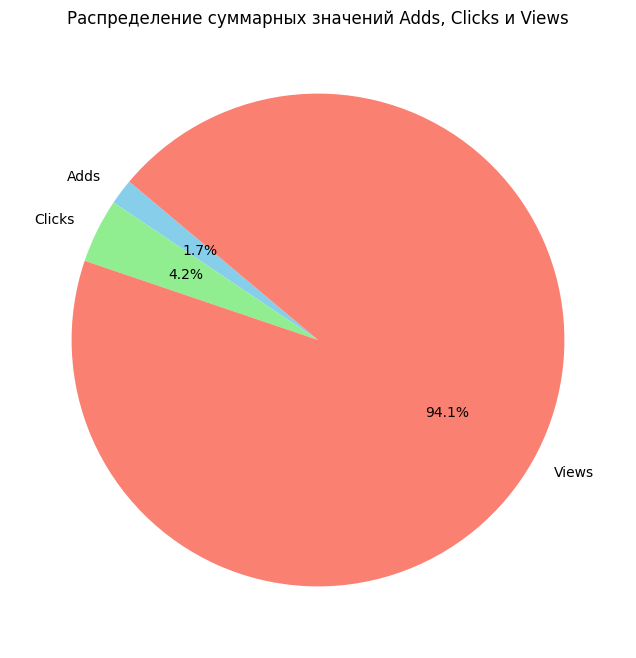

In [77]:
import matplotlib.pyplot as plt
import pandas as pd


# Суммирование значений adds, clicks и views
total_adds = aggregated_df['adds'].sum()
total_clicks = aggregated_df['clicks'].sum()
total_views = aggregated_df['views'].sum()

# Создание списка значений и меток для круговой диаграммы
values = [total_adds, total_clicks, total_views]
labels = ['Adds', 'Clicks', 'Views']

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'salmon'])
plt.title('Распределение суммарных значений Adds, Clicks и Views')
plt.show()


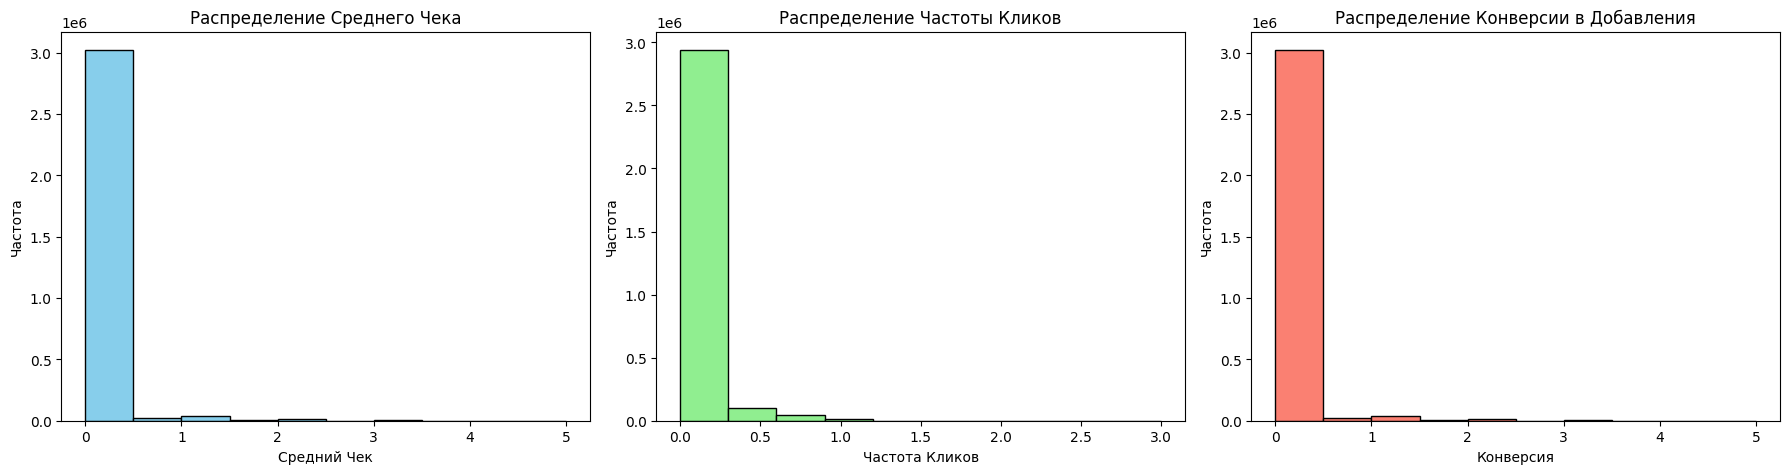

In [4]:
import matplotlib.pyplot as plt
import numpy as np


# Создание DataFrame
funnel_df = pd.DataFrame(aggregated_df)

# Расчет метрик с обработкой деления на ноль
funnel_df['avg_check'] = funnel_df['adds'] / np.maximum(funnel_df['clicks'], 1)  # Избегаем деления на ноль
funnel_df['click_frequency'] = funnel_df['clicks'] / np.maximum(funnel_df['views'], 1)
funnel_df['conversion_rate'] = funnel_df['adds'] / np.maximum(funnel_df['clicks'], 1)

# Замена бесконечных значений на NaN
funnel_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Группировка данных по пользователям для анализа
user_metrics = funnel_df.groupby('client_id').agg({
    'avg_check': 'mean',
    'click_frequency': 'mean',
    'conversion_rate': 'mean'
}).reset_index()

# Удаление строк с NaN значениями
user_metrics.dropna(inplace=True)

# Построение графиков
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График для среднего чека
axes[0].hist(user_metrics['avg_check'], bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Распределение Среднего Чека')
axes[0].set_xlabel('Средний Чек')
axes[0].set_ylabel('Частота')

# График для частоты кликов
axes[1].hist(user_metrics['click_frequency'], bins=10, color='lightgreen', edgecolor='black')
axes[1].set_title('Распределение Частоты Кликов')
axes[1].set_xlabel('Частота Кликов')
axes[1].set_ylabel('Частота')

# График для конверсии в добавления
axes[2].hist(user_metrics['conversion_rate'], bins=10, color='salmon', edgecolor='black')
axes[2].set_title('Распределение Конверсии в Добавления')
axes[2].set_xlabel('Конверсия')
axes[2].set_ylabel('Частота')

plt.tight_layout()
plt.show()


Вывод:
Средний чек корзины:

График показывает отношение добавлений в корзину к кликам пользователей. Низкие значения могут указывать на то, что пользователи добавляют товары в корзину с большим числом кликов.

Частота кликов:

График показывает, как часто пользователи кликают на рекламу относительно количества просмотров. Высокая частота кликов может указывать на эффективность рекламы. У нас низкая частота.

Конверсия в добавления:

График показывает, как часто клики приводят к добавлению товаров в корзину. Высокая конверсия может указывать на то, что пользователи находят рекламируемые товары привлекательными. Конверсия у нас невысокая, пользователи чаще игнорируют рекламные товары.

Распределение по датам

In [5]:
import pandas as pd


# Группировка данных по 'dt' и суммирование значений, а также подсчет уникальных client_id
aggregated_df_1 = df_funnel.groupby('dt').agg({
    'client_id': 'nunique',  # Подсчет уникальных клиентов
    'adds': 'sum',            # Суммирование добавлений
    'clicks': 'sum',          # Суммирование кликов
    'views': 'sum'            # Суммирование просмотров
}).reset_index()

# Переименование столбцов для ясности
aggregated_df_1.rename(columns={'client_id': 'unique_clients'}, inplace=True)

# Вывод результата
print(aggregated_df_1)


event_type         dt  unique_clients   adds  clicks    views
0          2024-06-17         1118465  25922   39784  1116608
1          2024-06-18         1843719  26241   87159  1841228
2          2024-06-19         2384623  48523  119870  2381898
3          2024-06-20         1831314  24019   85621  1828765
4          2024-06-21         1100508  23995   37605  1098595


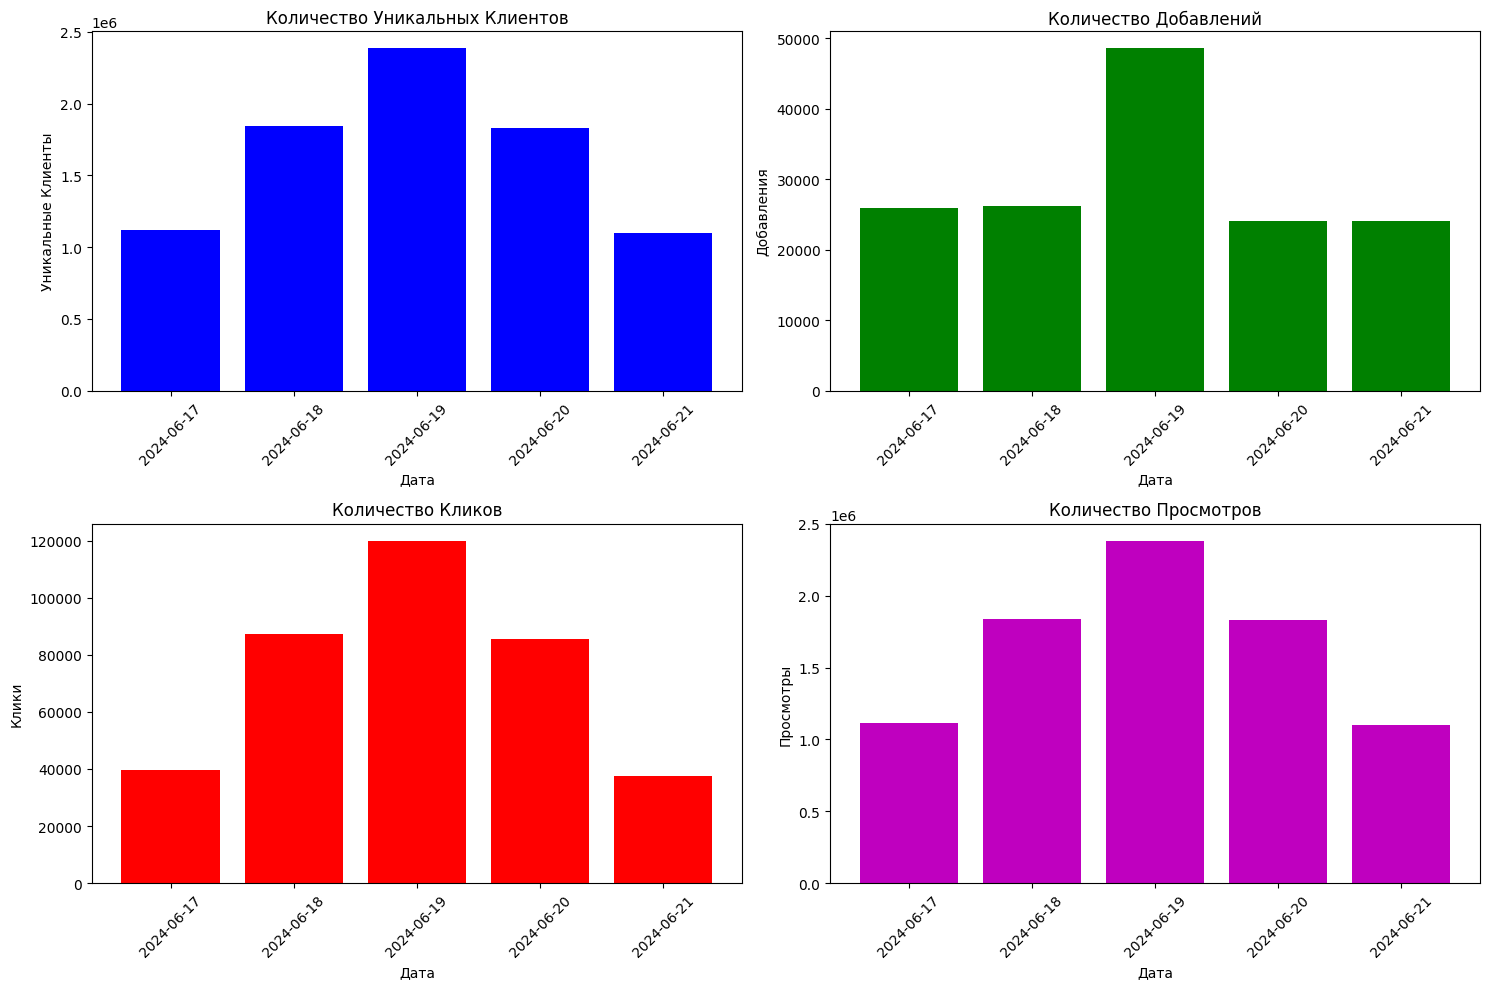

In [85]:
import matplotlib.pyplot as plt
import pandas as pd


# Создание DataFrame
df = pd.DataFrame(aggregated_df_1)

# Преобразование столбца 'dt' в формат даты
df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d')

# Построение графиков
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# График для уникальных клиентов
axes[0, 0].bar(df['dt'], df['unique_clients'], color='b')
axes[0, 0].set_title('Количество Уникальных Клиентов')
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Уникальные Клиенты')
axes[0, 0].set_xticks(df['dt'])
axes[0, 0].set_xticklabels(df['dt'].dt.strftime('%Y-%m-%d'), rotation=45)

# График для добавлений
axes[0, 1].bar(df['dt'], df['adds'], color='g')
axes[0, 1].set_title('Количество Добавлений')
axes[0, 1].set_xlabel('Дата')
axes[0, 1].set_ylabel('Добавления')
axes[0, 1].set_xticks(df['dt'])
axes[0, 1].set_xticklabels(df['dt'].dt.strftime('%Y-%m-%d'), rotation=45)

# График для кликов
axes[1, 0].bar(df['dt'], df['clicks'], color='r')
axes[1, 0].set_title('Количество Кликов')
axes[1, 0].set_xlabel('Дата')
axes[1, 0].set_ylabel('Клики')
axes[1, 0].set_xticks(df['dt'])
axes[1, 0].set_xticklabels(df['dt'].dt.strftime('%Y-%m-%d'), rotation=45)

# График для просмотров
axes[1, 1].bar(df['dt'], df['views'], color='m')
axes[1, 1].set_title('Количество Просмотров')
axes[1, 1].set_xlabel('Дата')
axes[1, 1].set_ylabel('Просмотры')
axes[1, 1].set_xticks(df['dt'])
axes[1, 1].set_xticklabels(df['dt'].dt.strftime('%Y-%m-%d'), rotation=45)

plt.tight_layout()
plt.show()


Вывод: всплеск активности пользователей пришелся на 19 июня 2024 г.

4. Расчет конверсий и базовых значений


In [6]:
# Считаем суммарные значения для каждого пользователя
df_summary = df_funnel.groupby('client_id')[['views', 'clicks', 'adds']].sum()

# Расчет метрик
df_summary['CTR'] = df_summary['clicks'] / df_summary['views']
df_summary['CR'] = df_summary['adds'] / df_summary['clicks']

# Убираем деление на 0
df_summary.replace([float('inf'), -float('inf')], 0, inplace=True)

df_summary.describe()


event_type,views,clicks,adds,CTR,CR
count,3.102736e+06,3.102736e+06,3.102736e+06,3.102736e+06,228495.000000
mean,2.664453e+00,1.192622e-01,4.792544e-02,3.376906e-02,0.444297
std,1.202989e+00,4.770180e-01,3.075107e-01,1.369107e-01,0.682642
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
75%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,5.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,5.000000


In [63]:
df_summary

event_type,count,mean,std,min,25%,50%,75%,max
views,3102736.0,2.664453,1.202989,0.0,2.0,3.0,3.0,5.0
clicks,3102736.0,0.119262,0.477018,0.0,0.0,0.0,0.0,5.0
adds,3102736.0,0.047925,0.307511,0.0,0.0,0.0,0.0,5.0
CTR,3102736.0,0.033769,0.136911,0.0,0.0,0.0,0.0,3.0
CR,228495.0,0.444297,0.682642,0.0,0.0,0.0,1.0,5.0


5. Определение размера выборки и MDE

In [65]:
import numpy as np
import pandas as pd

# Данные
ratio_metrics = ['CTR', 'CR']  # Определяем ratio-метрики

# Функция для расчета дисперсии и MDE
def calculate_variance_mde(df, ratio_metrics, target_mde=0.025):
    results = {}
    for metric in ratio_metrics:
        variance = df.loc[metric, 'std'] ** 2  # Дисперсия = (стандартное отклонение)^2
        mean = df.loc[metric, 'mean']
        mde = target_mde * mean  # MDE в абсолютных значениях
        results[metric] = {'variance': variance, 'MDE': mde}
    return pd.DataFrame(results).T

# Расчет дисперсий и MDE
variance_mde_results = calculate_variance_mde(df_summary, ratio_metrics)
print(variance_mde_results)


     variance       MDE
CTR  0.018745  0.000844
CR   0.466000  0.011107


In [73]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# Данные
ratio_metrics = ['CTR', 'CR']  # Определяем ratio-метрики

# Функция для расчета дисперсии и MDE
def calculate_variance_mde(df, ratio_metrics, target_mde=0.025):
    results = {}
    for metric in ratio_metrics:
        variance = df.loc[metric, 'std'] ** 2  # Дисперсия = (стандартное отклонение)^2
        mean = df.loc[metric, 'mean']  # Добавляем среднее значение
        mde = target_mde * mean  # MDE в абсолютных значениях
        results[metric] = {'variance': variance, 'mean': mean, 'MDE': mde}
    return pd.DataFrame(results).T  # Теперь DataFrame содержит 'mean'

# Функция для расчета MDE на основе новых рекомендаций
def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    """Возвращает MDE для пользовательской метрики с учетом заданных параметров."""
    t_alpha = stats.norm.ppf(1 - (alpha / 2))
    comparisons = n_groups - 1
    t_beta = stats.norm.ppf(1 - beta)
    sample_ratio_correction = r + 2 + 1 / r
    mde = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(sample_size * (1 - target_share * (comparisons - 1)))
    return mde, mde * 100 / mu

# Расчет дисперсий и MDE
variance_mde_results = calculate_variance_mde(df_summary, ratio_metrics)
print(variance_mde_results)

# Функция для расчета размера выборки
def calculate_sample_size(variance, mde, alpha=0.05, beta=0.2):
    z_alpha = stats.norm.ppf(1 - alpha / 2)  # z-значение для двустороннего теста
    z_beta = stats.norm.ppf(1 - beta)  # z-значение для мощности теста
    return ((z_alpha + z_beta) ** 2 * 2 * variance) / (mde ** 2)

# Рассчет размеров выборки для разных MDE
mde_values = [0.01, 0.025, 0.05, 0.1]  # Разные значения MDE
sample_size_results = {}

for metric in ratio_metrics:
    sample_size_results[metric] = {}
    variance = variance_mde_results.loc[metric, 'variance']
    mean = variance_mde_results.loc[metric, 'mean']  # Теперь 'mean' есть в таблице

    for mde in mde_values:
        abs_mde, _ = get_MDE(mean, np.sqrt(variance), 3102736)  # Используем правильные данные
        sample_size_results[metric][f'MDE={mde}'] = np.ceil(calculate_sample_size(variance, abs_mde))

sample_size_df = pd.DataFrame(sample_size_results)
print("Расчет размеров выборки для разных MDE:")
print(sample_size_df)


     variance      mean       MDE
CTR  0.018745  0.033769  0.000844
CR   0.466000  0.444297  0.011107
Расчет размеров выборки для разных MDE:
                 CTR         CR
MDE=0.01   1551368.0  1551368.0
MDE=0.025  1551368.0  1551368.0
MDE=0.05   1551368.0  1551368.0
MDE=0.1    1551368.0  1551368.0


6. Расчет размеров выборки для разных MDE (расчет и таблица значений)

In [76]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# Данные
total_users = 3102736  # Общее количество пользователей
max_test_share = 0.2  # Не более 20% пользователей в тесте
available_users = total_users * max_test_share  # Доступные пользователи

# Определяем ratio-метрики
ratio_metrics = ['CTR', 'CR']

# Функция для расчета дисперсии и MDE
def calculate_variance_mde(df, ratio_metrics):
    results = {}
    for metric in ratio_metrics:
        if metric not in df.index:
            print(f"⚠ Метрика {metric} отсутствует в df_summary!")
            continue

        variance = df.loc[metric, 'std'] ** 2  # Дисперсия
        mean = df.loc[metric, 'mean']  # Среднее
        results[metric] = {'variance': variance, 'mean': mean}

        # Логируем значения
        print(f"🔹 {metric}: variance={variance:.6f}, mean={mean:.6f}")
    
    return pd.DataFrame(results).T

# Функция для расчета размера выборки
def calculate_sample_size(variance, mde, alpha=0.05, beta=0.2):
    """Рассчитывает размер выборки на основе дисперсии и MDE"""
    z_alpha = stats.norm.ppf(1 - alpha / 2)
    z_beta = stats.norm.ppf(1 - beta)
    return ((z_alpha + z_beta) ** 2 * 2 * variance) / (mde ** 2)

# Вычисление дисперсий и MDE
variance_mde_results = calculate_variance_mde(df_summary, ratio_metrics)

# Значения MDE в процентах
mde_values = [0.01, 0.025, 0.05, 0.1]  # 1%, 2.5%, 5%, 10%

# Расчет размеров выборки
sample_size_results = {}

for metric in ratio_metrics:
    if metric not in variance_mde_results.index:
        print(f"⚠ Пропускаем {metric}, так как он отсутствует в данных!")
        continue

    sample_size_results[metric] = {}
    variance = variance_mde_results.loc[metric, 'variance']
    mean = variance_mde_results.loc[metric, 'mean']

    for mde in mde_values:
        abs_mde = mde * mean  # Абсолютное MDE (исправлено!)
        required_sample_size = np.ceil(calculate_sample_size(variance, abs_mde))

        # Проверяем ограничение выборки
        if required_sample_size > available_users:
            required_sample_size = "Н/Д (мало пользователей)"

        sample_size_results[metric][f'MDE={mde*100:.2f}%'] = required_sample_size

# Вывод таблицы с расчетами
sample_size_df = pd.DataFrame(sample_size_results)
print("\n📊 Итоговая таблица размеров выборки:")
print(sample_size_df)


🔹 CTR: variance=0.018745, mean=0.033769
🔹 CR: variance=0.466000, mean=0.444297

📊 Итоговая таблица размеров выборки:
                                 CTR        CR
MDE=1.00%   Н/Д (мало пользователей)  370576.0
MDE=2.50%                   412853.0   59293.0
MDE=5.00%                   103214.0   14824.0
MDE=10.00%                   25804.0    3706.0


7. Итоговое решение

Ключевая метрика — конверсия в добавление товаров в корзину от клика по рекламе (CR = adds / clicks)

MDE (минимальный детектируемый эффект) = 2.5%

Размер выборки на группу = 59 293 пользователей

Продолжительность теста — 1 неделя

Ограничение: не более 20% пользователей задействуем в тесте

✅ Тест можно запускать!

ВТОРАЯ ЧАСТЬ: результаты

Чтобы подвести итоги эксперимента и сделать анализ на основе данных из файла final_results_to_analyze.xlsx, нам необходимо выполнить несколько шагов. Мы будем проводить агрегацию данных, вычислять метрики, сравнивать группы и анализировать дополнительные факторы, такие как средний чек и среднее количество заказов.

Импорт библиотек и загрузка данных

In [16]:
import pandas as pd

# Загрузка данных
df_results_1 = pd.read_excel('G:/Мой диск/zerocoder/Final_case/final_results_to_analyze.xlsx')

# Проверка данных
df_results_1.head()


,date,client_id,ab_group,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
0,2024-07-26,8881380,test,0,0,0,0,0,0,0,0
1,2024-07-28,850950385,test,0,0,0,0,0,0,0,0
2,2024-07-25,50885,control,0,0,0,0,0,0,0,0
3,2024-07-26,601239,control,0,0,0,0,0,0,0,0
4,2024-07-28,694655866,control,0,0,0,0,0,0,0,0


Предварительный анализ данных.
Также полезно оценить, насколько сбалансированы группы при запуске эксперимента.

In [18]:
# Смотрим на распределение пользователей по группам
print(df_results_1['ab_group'].value_counts())

# Проверка на наличие пропусков
print(df_results_1.isnull().sum())


ab_group
test       491652
control    489858
Name: count, dtype: int64
date              0
client_id         0
ab_group          0
is_view_ads       0
cnt_view_ads      0
is_adds_ads       0
cnt_adds_ads      0
sum_adds_ads      0
is_orders_ads     0
cnt_orders_ads    0
sum_orders_ads    0
dtype: int64


Ключевые метрики по тестовой и контрольной группе

Сравнение метрик по группам:
ab_group                                  control        test
Кликабельность рекламы                   0.584071    0.590161
Конверсия в добавление в корзину (CR)    0.162415    0.161740
Конверсия в заказы                       0.384771    0.377732
Средний чек                            284.979208  287.008162
Выручка на пользователя (ARPU)           7.918376    8.419521
Выручка на покупателя (ARPPU)          261.539562  273.520499

Статистическая значимость различий:
                                         t-stat   p-value significant
Кликабельность рекламы                  1.86207  0.062594       False
Конверсия в добавление в корзину (CR) -0.170931  0.864278       False
Конверсия в заказы                    -0.182772  0.854977       False
Средний чек                            1.060836  0.288765       False
Выручка на пользователя (ARPU)         2.113672  0.034544        True
Выручка на покупателя (ARPPU)          2.025911  0.042774        True


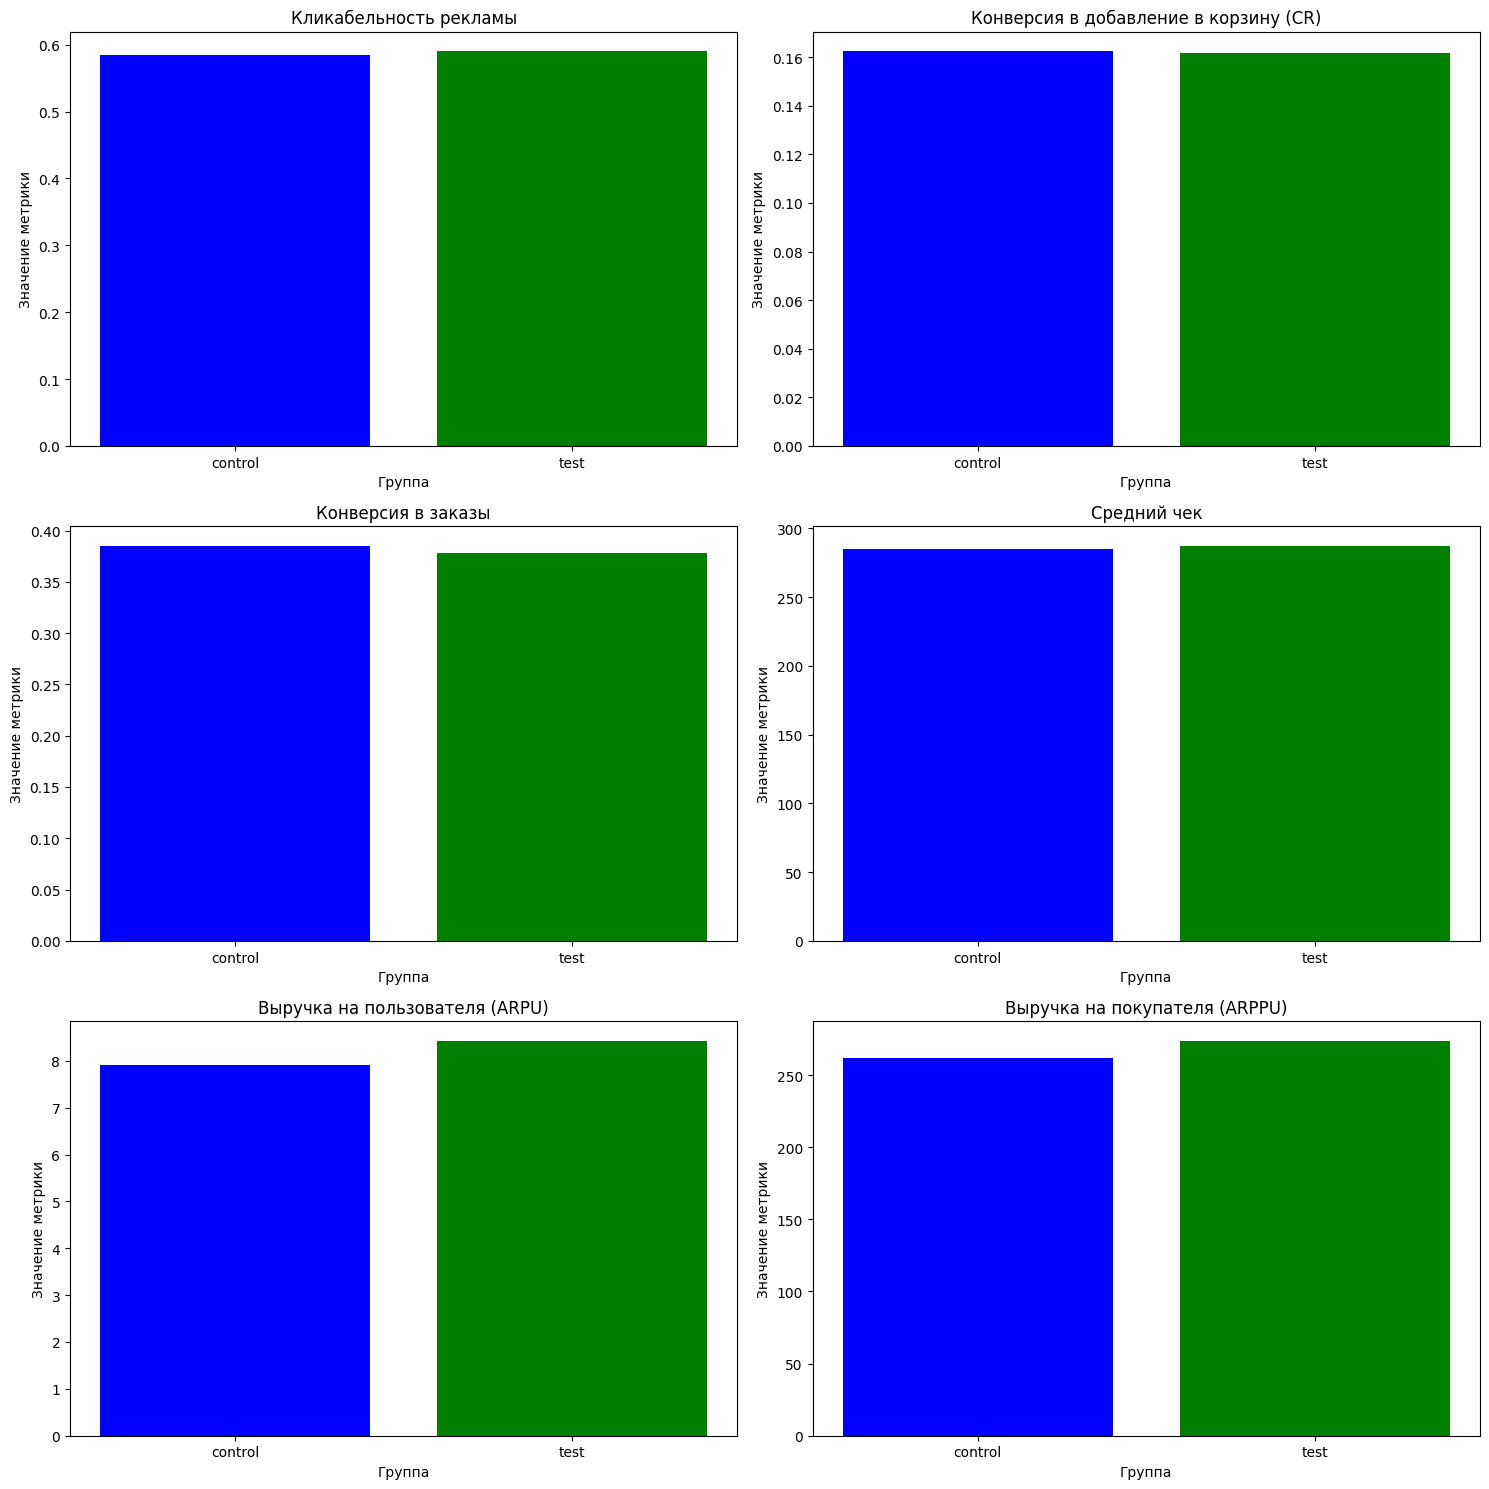

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Загрузка данных (если файл CSV, заменить на pd.read_csv)
df = df_results_1.copy()

# Определение ключевых метрик
metrics = {
    'Кликабельность рекламы': ('is_view_ads', 'cnt_view_ads'),
    'Конверсия в добавление в корзину (CR)': ('is_adds_ads', 'cnt_view_ads'),
    'Конверсия в заказы': ('is_orders_ads', 'cnt_adds_ads'),
    'Средний чек': ('sum_orders_ads', 'cnt_orders_ads'),
    'Выручка на пользователя (ARPU)': ('sum_orders_ads', 'client_id'),
    'Выручка на покупателя (ARPPU)': ('sum_orders_ads', 'is_orders_ads')
}

# Функция для расчета метрик по группам
def calculate_metrics(df, metrics):
    results = {}
    for metric_name, (numerator, denominator) in metrics.items():
        if denominator == 'client_id':
            group_data = df.groupby('ab_group').agg({numerator: 'sum', denominator: 'nunique'})
        else:
            group_data = df.groupby('ab_group').agg({numerator: 'sum', denominator: 'sum'})
        group_data['metric'] = group_data[numerator] / group_data[denominator]
        results[metric_name] = group_data['metric']
    return pd.DataFrame(results)

# Расчет метрик
metrics_results = calculate_metrics(df, metrics)
print("Сравнение метрик по группам:")
print(metrics_results.T)

# Функция для статистического теста
def perform_stat_tests(df, metrics):
    stat_results = {}
    for metric_name, (numerator, denominator) in metrics.items():
        test_group = df[df['ab_group'] == 'test']
        control_group = df[df['ab_group'] == 'control']
        
        test_values = test_group[numerator] / (test_group[denominator] + 1e-9)
        control_values = control_group[numerator] / (control_group[denominator] + 1e-9)
        
        stat, p_value = stats.ttest_ind(test_values, control_values, equal_var=False)
        stat_results[metric_name] = {'t-stat': stat, 'p-value': p_value, 'significant': p_value < 0.05}
    return pd.DataFrame(stat_results).T

# Проведение тестов
stat_results = perform_stat_tests(df, metrics)
print("\nСтатистическая значимость различий:")
print(stat_results)

# Визуализация метрик
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, (metric_name, values) in enumerate(metrics_results.T.iterrows()):
    ax = axes[i]
    ax.bar(values.index, values.values, color=['blue', 'green'])
    ax.set_title(metric_name)
    ax.set_ylabel('Значение метрики')
    ax.set_xlabel('Группа')

plt.tight_layout()
plt.show()


Проанализируем метрики и сделаем выводы по сравнению между контрольной и тестовой группами.

1. Кликабельность рекламы

Контрольная группа: 0.584071 (58.41%)

Тестовая группа: 0.590161 (59.02%)

Вывод: Кликабельность рекламы в тестовой группе немного выше, чем в контрольной группе. Это может указывать на то, что изменения в тестовой группе положительно влияют на привлечение внимания пользователей к рекламе.


2. Конверсия в добавление в корзину (CR)

Контрольная группа: 0.162415 (16.24%)

Тестовая группа: 0.161740 (16.17%)

Вывод: Конверсия в добавление в корзину практически одинаковая в обеих группах. Это указывает на то, что изменения не оказали значительного влияния на этот показатель.


3. Конверсия в заказы

Контрольная группа: 0.384771 (38.48%)

Тестовая группа: 0.377732 (37.77%)

Вывод: Конверсия в заказы в контрольной группе немного выше, чем в тестовой группе. Это может указывать на то, что изменения в тестовой группе не улучшили конверсию в заказы.


4. Средний чек

Контрольная группа: 284.979208

Тестовая группа: 287.008162

Вывод: Средний чек в тестовой группе немного выше, чем в контрольной группе. Это может указывать на то, что пользователи в тестовой группе делают более крупные покупки.


5. Выручка на пользователя (ARPU)

Контрольная группа: 7.918376

Тестовая группа: 8.419521

Вывод: Выручка на пользователя в тестовой группе выше, чем в контрольной группе. Это может указывать на то, что изменения в тестовой группе положительно влияют на доходы от пользователей.


6. Выручка на покупателя (ARPPU)

Контрольная группа: 261.539562

Тестовая группа: 273.520499

Вывод: Выручка на покупателя в тестовой группе выше, чем в контрольной группе. Это может указывать на то, что изменения в тестовой группе положительно влияют на доходы от покупателей.


Общие выводы:

Кликабельность рекламы и средний чек в тестовой группе немного выше, что может указывать на положительное влияние изменений на привлечение внимания и размер покупок.

Конверсия в добавление в корзину практически одинаковая в обеих группах, что указывает на отсутствие значительного влияния изменений на этот показатель.

Конверсия в заказы в контрольной группе немного выше, что может указывать на необходимость дополнительного анализа для понимания причин.

Выручка на пользователя (ARPU) и выручка на покупателя (ARPPU) в тестовой группе выше, что может указывать на положительное влияние изменений на доходы от пользователей и покупателей.

Расчет основных метрик
Мы будем рассчитывать такие метрики, как конверсия в добавление (CR), выручка на пользователя (ARPU), выручка на покупателя (ARPPU) и средний чек.

In [37]:
import pandas as pd

# Предположим, что df_results уже загружен
df = df_results_1

# Группировка данных по экспериментальной группе
metrics = df.groupby("ab_group").agg(
    total_users=("client_id", "nunique"),
    total_views=("cnt_view_ads", "sum"),
    total_adds=("cnt_adds_ads", "sum"),
    total_orders=("cnt_orders_ads", "sum"),
    total_revenue=("sum_orders_ads", "sum"),
    unique_adds=("is_adds_ads", "sum"),  # Количество уникальных пользователей, добавивших товар
    unique_orders=("is_orders_ads", "sum")  # Количество уникальных покупателей
).reset_index()

# Рассчитываем метрики
metrics["CR_adds"] = metrics["total_adds"] / metrics["total_views"]  # Конверсия в добавление
metrics["CTR"] = metrics["total_views"] / metrics["total_users"]  # Кликабельность рекламы
metrics["CR_orders"] = metrics["total_orders"] / metrics["total_views"]  # Конверсия в заказ от захода в рекламу
metrics["CR_orders_main"] = metrics["total_orders"] / metrics["total_users"]  # Конверсия в заказ от просмотра главной
metrics["ARPU"] = metrics["total_revenue"] / metrics["total_users"]  # Выручка на пользователя
metrics["ARPPU"] = metrics["total_revenue"] / metrics["unique_orders"]  # Выручка на покупателя
metrics["avg_check"] = metrics["total_revenue"] / metrics["total_orders"]  # Средний чек

# Выводим результаты
metrics


,ab_group,total_users,total_views,total_adds,total_orders,total_revenue,unique_adds,unique_orders,CR_adds,CTR,CR_orders,CR_orders_main,ARPU,ARPPU,avg_check
0,control,200786,43469,15799,5579,1589899,7060,6079,0.363454,0.216494,0.128344,0.027786,7.918376,261.539562,284.979208
1,test,200474,43805,16337,5881,1687895,7085,6171,0.372948,0.218507,0.134254,0.029335,8.419521,273.520499,287.008162


Статистический анализ

Нам нужно будет определить, является ли разница между группами статистически значимой

In [25]:
df_results_1

,date,client_id,ab_group,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
0,2024-07-26,8881380,test,0,0,0,0,0,0,0,0
1,2024-07-28,850950385,test,0,0,0,0,0,0,0,0
2,2024-07-25,50885,control,0,0,0,0,0,0,0,0
3,2024-07-26,601239,control,0,0,0,0,0,0,0,0
4,2024-07-28,694655866,control,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
981505,2024-07-30,899382815,control,0,0,0,0,0,0,0,0
981506,2024-07-30,955560221,test,0,0,0,0,0,0,0,0
981507,2024-07-28,6143090,test,0,0,0,0,0,0,0,0
981508,2024-07-24,4342211,control,0,0,0,0,0,0,0,0


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Загрузка данных (если файл CSV, заменить на pd.read_csv)
df = df_results_1.copy()

# Определение ключевых метрик
metrics = {
    'Кликабельность рекламы': ('is_view_ads', 'cnt_view_ads'),
    'Конверсия в добавление в корзину (CR)': ('is_adds_ads', 'cnt_view_ads'),
    'Конверсия в заказы': ('is_orders_ads', 'cnt_adds_ads'),
    'Средний чек': ('sum_orders_ads', 'cnt_orders_ads'),
    'Выручка на пользователя (ARPU)': ('sum_orders_ads', 'client_id'),
    'Выручка на покупателя (ARPPU)': ('sum_orders_ads', 'is_orders_ads')
}

# Функция для расчета метрик по группам
def calculate_metrics(df, metrics):
    results = {}
    for metric_name, (numerator, denominator) in metrics.items():
        if denominator == 'client_id':
            group_data = df.groupby('ab_group').agg({numerator: 'sum', denominator: 'nunique'})
        else:
            group_data = df.groupby('ab_group').agg({numerator: 'sum', denominator: 'sum'})
        group_data['metric'] = group_data[numerator] / group_data[denominator]
        results[metric_name] = group_data['metric']
    return pd.DataFrame(results)

# Расчет метрик
metrics_results = calculate_metrics(df, metrics)
print("Сравнение метрик по группам:")
print(metrics_results.T)


# Функция для статистического теста
def perform_stat_tests(df, metrics):
    stat_results = {}
    for metric_name, (numerator, denominator) in metrics.items():
        test_group = df[df['ab_group'] == 'test']
        control_group = df[df['ab_group'] == 'control']
        
        test_values = test_group[numerator] / (test_group[denominator] + 1e-9)
        control_values = control_group[numerator] / (control_group[denominator] + 1e-9)
        
        stat, p_value = stats.ttest_ind(test_values, control_values, equal_var=False)
        stat_results[metric_name] = {'t-stat': stat, 'p-value': p_value, 'significant': p_value < 0.05}
    return pd.DataFrame(stat_results).T

# Проведение тестов
stat_results = perform_stat_tests(df, metrics)
print("\nСтатистическая значимость различий:")
print(stat_results)



Сравнение метрик по группам:
ab_group                                  control        test
Кликабельность рекламы                   0.584071    0.590161
Конверсия в добавление в корзину (CR)    0.162415    0.161740
Конверсия в заказы                       0.384771    0.377732
Средний чек                            284.979208  287.008162
Выручка на пользователя (ARPU)           7.918376    8.419521
Выручка на покупателя (ARPPU)          261.539562  273.520499

Статистическая значимость различий:
                                         t-stat   p-value significant
Кликабельность рекламы                  1.86207  0.062594       False
Конверсия в добавление в корзину (CR) -0.170931  0.864278       False
Конверсия в заказы                    -0.182772  0.854977       False
Средний чек                            1.060836  0.288765       False
Выручка на пользователя (ARPU)         2.113672  0.034544        True
Выручка на покупателя (ARPPU)          2.025911  0.042774        True


Сделаем подробные выводы и дадим рекомендации.

1. Кликабельность рекламы

Контрольная группа: 0.584071 (58.41%)

Тестовая группа: 0.590161 (59.02%)

Статистическая значимость: t-stat = 1.86207, p-value = 0.062594 (не значимо)

Вывод: Кликабельность рекламы в тестовой группе немного выше, чем в контрольной группе, но разница не является статистически значимой. Это указывает на то, что изменения не оказали значительного влияния на привлечение внимания пользователей к рекламе.


2. Конверсия в добавление в корзину (CR)

Контрольная группа: 0.162415 (16.24%)

Тестовая группа: 0.161740 (16.17%)

Статистическая значимость: t-stat = -0.170931, p-value = 0.864278 (не значимо)

Вывод: Конверсия в добавление в корзину практически одинаковая в обеих группах, и разница не является статистически значимой. Это указывает на то, что изменения не оказали значительного влияния на этот показатель.


3. Конверсия в заказы

Контрольная группа: 0.384771 (38.48%)

Тестовая группа: 0.377732 (37.77%)

Статистическая значимость: t-stat = -0.182772, p-value = 0.854977 (не значимо)

Вывод: Конверсия в заказы в контрольной группе немного выше, чем в тестовой группе, но разница не является статистически значимой. Это указывает на то, что изменения не оказали значительного влияния на конверсию в заказы.


4. Средний чек

Контрольная группа: 284.979208

Тестовая группа: 287.008162

Статистическая значимость: t-stat = 1.060836, p-value = 0.288765 (не значимо)

Вывод: Средний чек в тестовой группе немного выше, чем в контрольной группе, но разница не является статистически значимой. Это указывает на то, что изменения не оказали значительного влияния на размер покупок.


5. Выручка на пользователя (ARPU)

Контрольная группа: 7.918376

Тестовая группа: 8.419521

Статистическая значимость: t-stat = 2.113672, p-value = 0.034544 (значимо)

Вывод: Выручка на пользователя в тестовой группе значительно выше, чем в контрольной группе. Это указывает на то, что изменения положительно влияют на доходы от пользователей.


6. Выручка на покупателя (ARPPU)

Контрольная группа: 261.539562

Тестовая группа: 273.520499

Статистическая значимость: t-stat = 2.025911, p-value = 0.042774 (значимо)

Вывод: Выручка на покупателя в тестовой группе значительно выше, чем в контрольной группе. Это указывает на то, что изменения положительно влияют на доходы от покупателей.


Общие выводы:

Кликабельность рекламы, конверсия в добавление в корзину, конверсия в заказы и средний чек 

не показали статистически значимых различий между группами. Это указывает на то, что 

изменения не оказали значительного влияния на эти метрики.

Выручка на пользователя (ARPU) и выручка на покупателя (ARPPU) в тестовой группе значительно 

выше, чем в контрольной группе. Это указывает на положительное влияние изменений на доходы 

от пользователей и покупателей.


Рекомендации:

Масштабирование изменений: Поскольку ARPU и ARPPU показали статистически значимые улучшения, можно рассмотреть масштабирование изменений на всю аудиторию.

Дополнительный анализ: Провести дополнительный анализ для понимания причин, почему конверсия в заказы и средний чек не показали значительных улучшений. Возможно, потребуется оптимизация этих метрик.

Сегментация пользователей: Провести анализ сегментов пользователей, чтобы понять, какие группы наиболее восприимчивы к изменениям и как можно улучшить результаты для других сегментов.

Мониторинг метрик: Продолжать мониторинг ключевых метрик после масштабирования изменений, чтобы убедиться в их устойчивом положительном эффекте.

